How to set priors on stellar parameters.  
gully

https://github.com/iancze/Starfish/issues/32

The strategy here is to define a lnprior and add it to the lnprob.  
We have to find the right destination in the code.

# Preamble

### Highlighting lines of code in markdown.
The Jupyter Notebook does not have a way to highlight lines of code in markdown.  Sphinx and reST have a way of doing this, but not here.  Too bad.  So to draw attention to a specific line in large code blocks I will use three arrows:
 ```python
>>>
```
Cool?  Cool.

### Nomenclature: Log- Likelihood, Prior, Probability

>Throughout the code `lnprob` denotes the natural log of the posterior probability density distribution.  This practice is completely accurate, since the priors are (tacitly) flat.  However now I am trying to add in *explicit prior* functionality.  So I am faced with the challenge of renaming `lnprob` everywhere to `lnlike`, or just reassigning in place: `lnprob` += `lnprior`.  I will do the latter.  But note that it could be confusing whether you're looking at a `lnprob` value that includes the (new, explicit) prior or not.

# Attempt 1: Put the prior in `star.py`

At first I thought the right place to make this change is in the script:
### `star.py`'s  `lnprob()`
  
  

```python
# These functions store the variables pconns, cconns, ps.
def lnprob(p):
    pars = ThetaParam(grid=p[0:3], vz=p[3], vsini=p[4], logOmega=p[5])
    #Distribute the calculation to each process
    for ((spectrum_id, order_id), pconn) in pconns.items():
        pconn.send(("LNPROB", pars))

    #Collect the answer from each process
    lnps = np.empty((len(Starfish.data["orders"]),))
    for i, pconn in enumerate(pconns.values()):
        lnps[i] = pconn.recv()

>>> result = np.sum(lnps) # + lnprior???
    print("proposed:", p, result)
    return result
```

###  `star.py` is not the right place to put the prior\*.  
\*I think.  I'm not 100% certain because this part of the code is *meta*.  

`query_lnprob()` does not have access to the `p.grid` attribute, so it *can't* compute a prior.  
Otherwise we'd be ln(likelihood) with ln(prob).  We can't do it this way.  


```python
def query_lnprob():
        for ((spectrum_id, order_id), pconn) in pconns.items():
            pconn.send(("GET_LNPROB", None))

        #Collect the answer from each process
        lnps = np.empty((len(Starfish.data["orders"]),))
        for i, pconn in enumerate(pconns.values()):
            lnps[i] = pconn.recv()

>>>     result = np.sum(lnps) # Can't put prior here.  Don't know p!
        print("queried:", result)
        return result
```

# Attempt 2: Put the prior in `parallel.py`

This is what I'm doing right now and it seems to work.

```python
def lnprob_Theta(self, p):
    '''
    Update the model to the Theta parameters and then evaluate the lnprob.

    Intended to be called from the master process via the command "LNPROB".
    NOTE that setting the prior this way means:
        The prior will only be effective when called from `update_Theta`
        This could cause some unanticipated behavior...
    '''
    try:
        self.update_Theta(p)
        lnlike = self.evaluate() # Also sets self.lnprob to new value
>>>     lnp = lnlike + self.lnprior_fn(p)  # Here is the prior!!
        self.lnprob = lnp
        return lnp
    except C.ModelError:
        self.logger.debug("ModelError in stellar parameters, sending back -np.inf {}".format(p))
        return -np.inf
```

This seems to work fine, but the problem is that `lnlike` is defined in 3 or 4 different places.  (double check this)

1. OptimizeCheb
2. SampleThetaCheb
3. SampleThetaPhi
4. SampleThetaPhiLines

So the fix above is only affecting one of those.  The *better* solution would be to put the prior directly in `evaluate`, which is shared among the above 4.  But I'd have to use self.p, which I'm not certain is actually defined.  It's also hard to debug the `parallel.py`, especially since it is wrapped in an argparser.  

Anyways, here is the lnprior_fn, which is very stupidly hardcoded at the moment.  

```python
    def lnprior_fn(self, p):
        '''
        Return the lnprior for input stellar parameters.

        Intended to be called from lnprob_Theta
        '''
        #For now just hardcode the location and scale parameters.
        # log-g
        loc = 3.7
        scl = 0.02
        lnprior_logg = norm.logpdf(p.grid[1], loc=loc, scale=scl)
        #Everything else will have a flat prior over the grid.
        lnprior_allelse = 0.0
        lnprior_out = lnprior_logg + lnprior_allelse
        return lnprior_out
```

The leads me to the other big question:  

How to actually get the prior parameters into the right place?  
The `config.yaml` probably, but the details need to be worked out.

# What does this prior look like?

In [38]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [39]:
% config InlineBackend.figure_format = 'retina'

We want a a continuous prior:

In [51]:
from scipy import stats

In [52]:
x = np.linspace(3.5, 4.0, 100)
loc = 3.7
scl = 0.02
y = stats.norm.pdf(x, loc=loc, scale=scl)
yalt = stats.norm.logpdf(x, loc=loc, scale=scl)

In [53]:
np.trapz(y, x) 

1.0

The normalization doesn't matter, but it's nice to know that it's close to normalized.

(-20, 20.0)

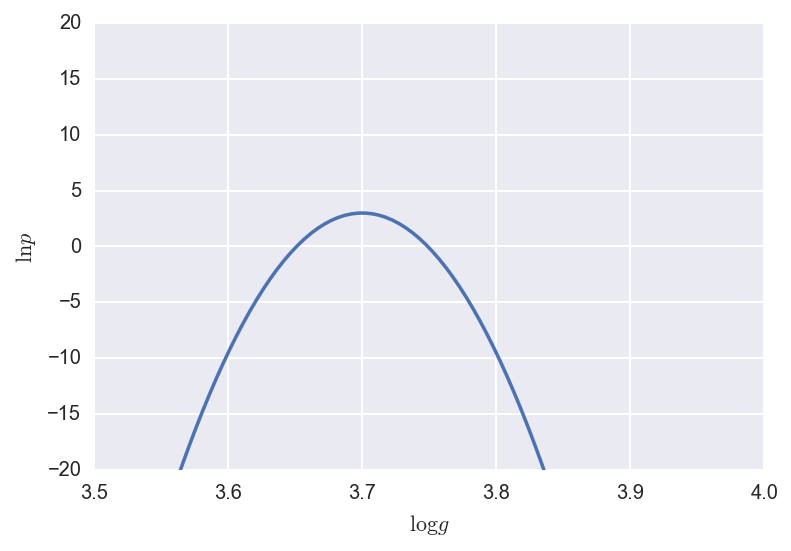

In [55]:
plt.plot(x, np.log(y))
plt.xlabel('$\log{g}$')
plt.ylabel('$\ln{p}$')
plt.ylim(ymin=-20)

In [47]:
def lnprior_fn(self, p):
    #For now just hardcode the location and scale parameters.
    # log-g
    loc = 3.7
    scl = 0.1
    lnprior_logg = stats.norm.logpdf(p.grid[1], loc=loc, scale=scl)
    #Everything else will have a flat prior over the grid.
    lnprior_allelse = 0.0
    lnprior_out = lnprior_logg + lnprior_allelse
    return lnprior_out

## What do the chains look like when you use a prior?

In [23]:
import h5py

In [24]:
!cp /Users/gully/GitHub/welter/sf/m086/output/LkCa4_sm086/run03/mc.hdf5 .

In [27]:
f = h5py.File('mc.hdf5', mode='r')

In [28]:
list(f.keys())

['samples']

In [29]:
d = f['samples']

In [31]:
list(d.attrs)

['acceptance', 'commit']

In [32]:
d.attrs['acceptance']

'0.002'

Too small!  Here's why:  Our starting guess for log-g was 3.6.  But the prior was a narrow Gaussian at 3.7.  
But it still should have done better than 0.002.  Whatever.

I am pretty sure we should include the prior directly in the evaluate step.  

Otherwise initial conditions could cause strange lnprob values.  (It's hard to tell which call to lnprob is initialized first-- with or without lnprior).

In [33]:
f.close()

## Chains before and after (explicit) priors are set.

<p style="float: left; font-size: 9pt; text-align: center; width: 47%; margin-right: 1%; margin-bottom: 0.5em;"><img src=walkers_prior_0p1_scale.png style="width: 100%">Gaussian prior with 0.1 width</p><p style="float: left; font-size: 9pt; text-align: center; width: 47%; margin-right: 1%; margin-bottom: 0.5em;"><img src=walkers_prior_0p02_scale.png style="width: 100%">Gaussian prior with 0.02 width</p><p style="clear: both;">

The second chain from the top is the $\log{g}$ chain.  Here we see that setting the prior scale tighter made the range of variation much less.  Not that we had different initial starting values.  The value $3.7\pm0.1$ comes from literature values so we will use that.

## The path ahead

Well, I have to think some more about how to best implement this system.

# The end.